## CH5.S2: Bivariate copulas for claims by site

This script will be divided into two parts:

1. Copulas for raw claims by site
2. Copulas for detrended claims by site

In [1]:
#loading the required libraries:
import copulas as copulas
import pycop
import time
import numpy as np
import itertools
import random
import tqdm
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as ss

### PART 1. COPULAS FOR RAW CLAIMS BY SITE

In [2]:
#loading the raw claims dataset:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Raw by Type/aggregated_series.csv")
df.describe()

,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,229.743590,43393.384423,255.448718,45801.327436,388.096154,59298.647628,120.897436,37450.703013
std,182.140955,23012.955179,208.589651,41028.606035,377.259229,59463.309234,56.016954,18528.229545
min,15.000000,4465.960000,14.000000,2033.880000,14.000000,1964.960000,14.000000,4121.360000
25%,127.750000,30391.940000,112.750000,18697.077500,157.250000,23802.515000,87.750000,26471.802500
50%,150.000000,37980.400000,152.000000,26495.180000,196.000000,30811.005000,105.500000,34139.190000
75%,259.500000,53313.577500,377.000000,62260.750000,507.500000,77035.832500,150.000000,46662.660000
max,873.000000,133835.070000,1007.000000,196328.290000,1670.000000,261424.430000,337.000000,137850.990000


#### 1. Upper tail dependence coefficients

In [13]:
#CBX and CPX:
pd.set_option('mode.chained_assignment',None)
from pycop.bivariate.copula import empirical
cop1 = empirical(df[['cbx', 'cpx']])
print(cop1.optimal_tdc("upper"), cop1.UTDC(0.89))

Optimal threshold:  0.1794871794871795
0.8454262475495917 0.6596736596736592


In [15]:
#CBS and CPS:
from pycop.bivariate.copula import empirical
cop2 = empirical(df[['cbs', 'cps']])
print(cop2.optimal_tdc("upper"), cop2.UTDC(0.89))

Optimal threshold:  0.10897435897435898
0.5970453884336415 0.6013986013986011


In [17]:
#CBX and CBS:
from pycop.bivariate.copula import empirical
cop3 = empirical(df[['cbx', 'cbs']])
print(cop3.optimal_tdc("upper"), cop3.UTDC(0.89))

Optimal threshold:  0.10897435897435898
0.9241666666666665 0.9510489510489506


In [18]:
#CPX and CPS:
from pycop.bivariate.copula import empirical
cop4 = empirical(df[['cpx', 'cps']])
print(cop4.optimal_tdc("upper"), cop4.UTDC(0.89))

Optimal threshold:  0.28205128205128205
0.748521712519952 0.6596736596736592


#### 2. Fitting Archimedean copulas

To find the best Archimedean copulas, the marginals will be fit in pairs and then tested using select() from the copulas library

In [45]:
#adding the marginals to the existing dataframe 
df['Fcbx'] = ss.nbinom.cdf(df['cbx'], 1.3966908444521602, 0.003585989036498995)
df['Fcpx'] = ss.nbinom.cdf(df['cpx'], 4.676652646199874, 0.03724209891451029)
df['Fcbs'] = ss.loglaplace.cdf(df['cbs'], 1.4149894458208154, 0, 30811.296859671424)
df['Fcps'] = ss.loglaplace.cdf(df['cps'],  2.470615641302211, 0, 34138.78552976878)
df.iloc[:,9:].head()

,Fcbx,Fcpx,Fcbs,Fcps
0,0.271710,0.989218,0.377477,0.945554
1,0.598800,0.907123,0.789324,0.825441
2,0.719123,0.946840,0.875313,0.877552
3,0.845961,0.756486,0.920376,0.825874
4,0.791736,0.756486,0.904909,0.689488


**1. CBX AND CPX**

In [46]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
#Selecting the best copula for cpx and cbx 
from copulas.bivariate import select_copula 
X1 = df[['Fcbx', 'Fcpx']].to_numpy()
X1.shape
select_copula(X1)

In [47]:
#fitting the Frank copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist1 = Bivariate(copula_type='frank')
dist1.fit(X1)
dist1.tau, dist1.theta

(0.6856157260178235, 10.78257260214861)

In [49]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop1 = archimedean(family="frank")
cop1.LTDC(theta=dist1.theta), cop1.UTDC(theta=dist1.theta) 

(0, 0)

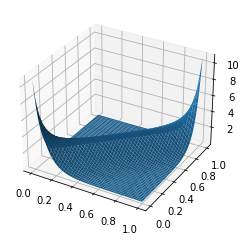

In [50]:
cop1.plot_pdf(theta=dist1.theta, Nsplit=50)

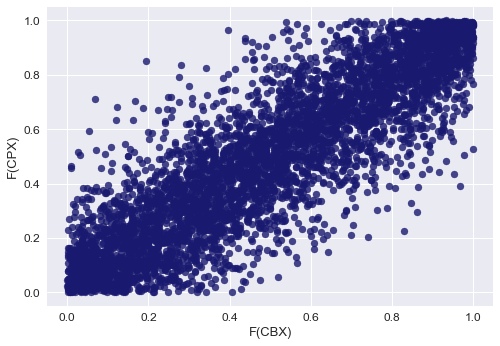

In [13]:
#simulating with this Frank copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_frank(num=5000, theta=dist1.theta)
plt.scatter(u1, u2, color="midnightblue", alpha=0.8)
plt.xlabel("F(CBX)", fontsize=13)
plt.ylabel("F(CPX)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_cbx_cpx.png', dpi=300, bbox_inches='tight')

**2. CBS AND CPS**

In [51]:
#Selecting the best copula for cbs and cps:
from copulas.bivariate import select_copula 
X2 = df[['Fcbs', 'Fcps']].to_numpy()
X2.shape
select_copula(X2)

In [52]:
#fitting the Clayton copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist2 = Bivariate(copula_type='clayton')
dist2.fit(X2)
dist2.tau, dist2.theta

(0.47692307692307695, 1.8235294117647063)

In [53]:
#checking upper and lower tail dependency:
cop2 = archimedean(family="clayton")
cop2.LTDC(theta=dist2.theta), cop2.UTDC(theta=dist2.theta) 

(0.6837841577631962, 0)

C:\Users\r_jun\miniconda3\envs\py36\lib\site-packages\pycop\bivariate\copula.py:10: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(U,V,Z)


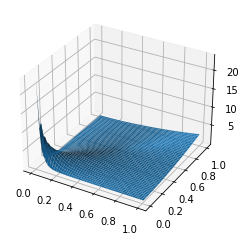

In [54]:
cop2.plot_pdf(theta=dist2.theta, Nsplit=50)

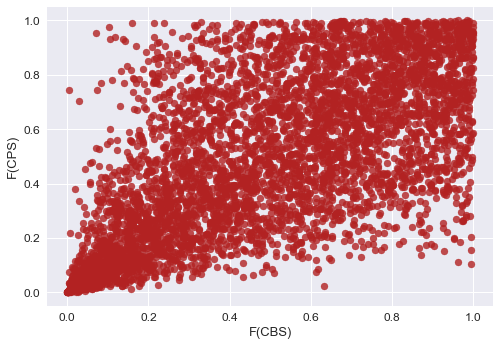

In [18]:
#simulating with this Clayton copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist2.theta)
plt.scatter(u1, u2, color="firebrick", alpha=0.8)
plt.xlabel("F(CBS)", fontsize=13)
plt.ylabel("F(CPS)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_cbs_cps.png', dpi=300, bbox_inches='tight')

**3. CBX AND CBS**

In [55]:
#Selecting the best copula for cbx and cbs 
from copulas.bivariate import select_copula 
X3 = df[['Fcbx', 'Fcbs']].to_numpy()
X3.shape
select_copula(X3)

In [56]:
#fitting the Gumbel copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist3 = Bivariate(copula_type='gumbel')
dist3.fit(X3)
dist3.tau, dist3.theta

(0.869743747247143, 7.6771746374230485)

In [57]:
#checking upper and lower tail dependency:
cop3 = archimedean(family="gumbel")
cop3.LTDC(theta=dist3.theta), cop3.UTDC(theta=dist3.theta) 

(0, 0.9055119120735025)

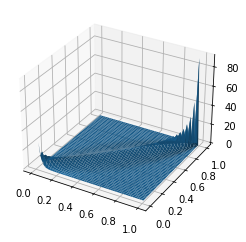

In [58]:
cop3.plot_pdf(theta=dist3.theta, Nsplit=50)

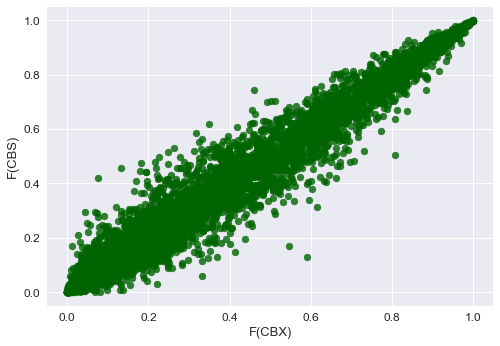

In [22]:
#simulating with this Gumbel copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_gumbel(num=5000, theta=dist3.theta)
plt.scatter(u1, u2, color="darkgreen", alpha=0.8)
plt.xlabel("F(CBX)", fontsize=13)
plt.ylabel("F(CBS)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_cbx_cbs.png', dpi=300, bbox_inches='tight')

**4. CPX AND CPS**

In [59]:
#Selecting the best copula for cpx and cps 
from copulas.bivariate import select_copula 
X4 = df[['Fcpx', 'Fcps']].to_numpy()
X4.shape
select_copula(X4)

In [60]:
#fitting the Clayton copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist4 = Bivariate(copula_type='clayton')
dist4.fit(X4)
dist4.tau, dist4.theta

(0.6619106381064683, 3.9155957726638664)

In [61]:
#checking upper and lower tail dependency:
cop4 = archimedean(family="clayton")
cop4.LTDC(theta=dist4.theta), cop4.UTDC(theta=dist4.theta) 

(0.8377612282588635, 0)

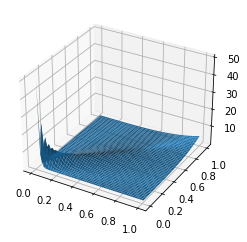

In [62]:
cop4.plot_pdf(theta=dist4.theta, Nsplit=50)

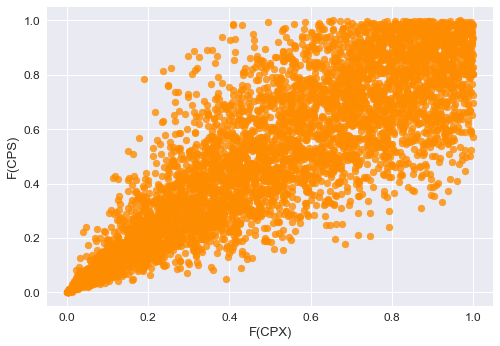

In [27]:
#simulating with this Clayton copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist4.theta)
plt.scatter(u1, u2, color="darkorange", alpha=0.8)
plt.xlabel("F(CPX)", fontsize=13)
plt.ylabel("F(CPS)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_cpx_cps.png', dpi=300, bbox_inches='tight')

### PART 2. COPULAS FOR DETRENDED CLAIMS BY SITE

In [28]:
df = pd.read_csv("C:/Users/r_jun/Documents/ISEG MSc Actuarial Science/Thesis/Python/FINAL/CH4/Detrended by Type/aggregated_detrended_series.csv")
df.describe()

,Unnamed: 0,pdx,pds,plx,pls,cbx,cbs,cpx,cps
count,156.000000,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02,1.560000e+02
mean,77.500000,3.753123e-14,1.770017e-11,-1.552263e-13,2.938367e-12,5.757218e-14,8.581899e-12,-3.666583e-15,2.775125e-12
std,45.177428,8.981529e+01,1.394064e+04,1.167014e+02,2.230552e+04,1.980951e+02,3.275734e+04,2.876242e+01,1.251592e+04
min,0.000000,-4.223615e+02,-4.634860e+04,-4.378416e+02,-7.900797e+04,-1.036661e+03,-1.651316e+05,-8.746980e+01,-2.681667e+04
25%,38.750000,-3.907830e+01,-6.181272e+03,-7.741136e+01,-1.125709e+04,-8.708965e+01,-1.401144e+04,-1.350966e+01,-8.766360e+03
50%,77.500000,1.889838e+00,8.814776e+02,-2.758647e+00,-2.496194e+03,-1.386099e+00,-2.069880e+03,2.265712e+00,1.125036e+02
75%,116.250000,3.550041e+01,5.587979e+03,7.064126e+01,1.019178e+04,8.913627e+01,1.233685e+04,1.582114e+01,6.153436e+03
max,155.000000,3.640041e+02,5.674145e+04,4.779544e+02,9.445369e+04,7.507874e+02,1.196577e+05,1.289910e+02,7.465435e+04


In [31]:
#adding the marginals to the detrended claim sites:
df['Fcbx'] = ss.hypsecant.cdf(df['cbx'], 6.341120731910746e-14, 106.49317688046042)
df['Fcpx'] = ss.nct.cdf(df['cpx'], 3.8931146739405342, -0.5140487046086466, 12.836944500934292, 20.3164124897376653)
df['Fcbs'] = ss.t.cdf(df['cbs'], df=2.216470896932953, loc=-1857.8884396683388, scale=15819.194302879092)
df['Fcps'] = ss.dgamma.cdf(df['cps'], 2.216470896932953, -1857.8884396683388, 15819.194302879092)
df.iloc[:,9:].head()

,Fcbx,Fcpx,Fcbs,Fcps
0,0.000038,0.921963,0.003229,0.583407
1,0.000341,0.048430,0.005435,0.385071
2,0.001236,0.180752,0.009357,0.469561
3,0.008979,0.010932,0.022204,0.404678
4,0.004317,0.012350,0.016577,0.298894


**1. DCBX AND DCPX**

In [32]:
#Selecting the best copula for dcbx and dcpx 
from copulas.bivariate import select_copula 
X1 = df[['Fcbx', 'Fcpx']].to_numpy()
X1.shape
select_copula(X1)

In [33]:
#fitting the Clayton copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist1 = Bivariate(copula_type='clayton')
dist1.fit(X1)
dist1.tau, dist1.theta

(0.3680727874276261, 1.1649214659685865)

In [34]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop1 = archimedean(family="clayton")
cop1.LTDC(theta=dist1.theta), cop1.UTDC(theta=dist1.theta) 

(0.5515536133067402, 0)

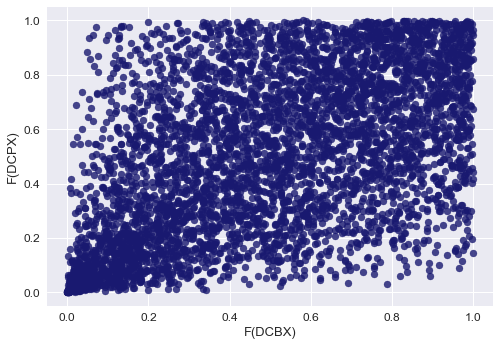

In [35]:
#simulating with this Clayton copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist1.theta)
plt.scatter(u1, u2, color="midnightblue", alpha=0.8)
plt.xlabel("F(DCBX)", fontsize=13)
plt.ylabel("F(DCPX)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_dcbx_dcpx.png', dpi=300, bbox_inches='tight')

**2. DCBS AND DCPS**

In [36]:
#Selecting the best copula for dcbs and dcps 
from copulas.bivariate import select_copula 
X2 = df[['Fcbs', 'Fcps']].to_numpy()
X2.shape
select_copula(X2)

In [37]:
#fitting the Clayton copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist2 = Bivariate(copula_type='clayton')
dist2.fit(X2)
dist2.tau, dist2.theta

(0.17204301075268816, 0.41558441558441556)

In [38]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop2 = archimedean(family="clayton")
cop2.LTDC(theta=dist2.theta), cop2.UTDC(theta=dist2.theta) 

(0.18864555344917786, 0)

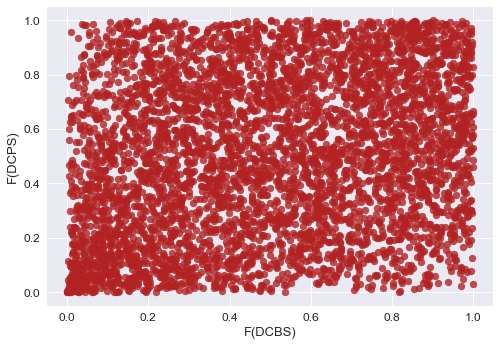

In [39]:
#simulating with this Clayton copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist2.theta)
plt.scatter(u1, u2, color="firebrick", alpha=0.8)
plt.xlabel("F(DCBS)", fontsize=13)
plt.ylabel("F(DCPS)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_dcbs_dcps.png', dpi=300, bbox_inches='tight')

**3. DCBX AND DCBD**

In [40]:
#Selecting the best copula for dcbx and dcbs 
from copulas.bivariate import select_copula 
X3 = df[['Fcbx', 'Fcbs']].to_numpy()
X3.shape
select_copula(X3)

In [41]:
#fitting the Gumbel copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist3 = Bivariate(copula_type='gumbel')
dist3.fit(X3)
dist3.tau, dist3.theta

(0.821505376344086, 5.602409638554217)

In [42]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop3 = archimedean(family="gumbel")
cop3.LTDC(theta=dist3.theta), cop3.UTDC(theta=dist3.theta) 

(0, 0.8682976028956546)

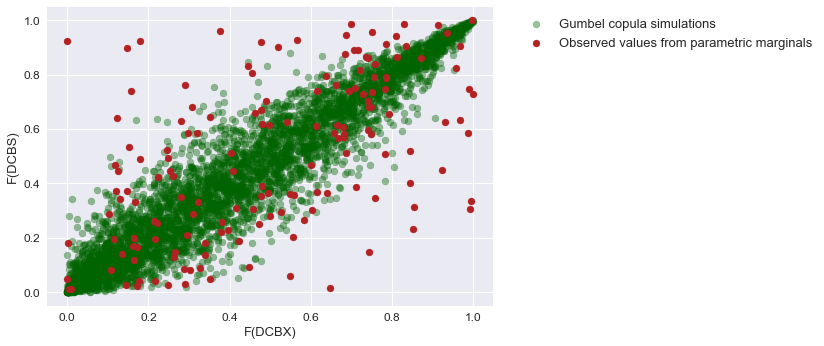

In [43]:
#simulating with this Gumbel copula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_gumbel(num=5000, theta=dist3.theta)
plt.scatter(u1, u2, color="darkgreen", alpha=0.4, label="Gumbel copula simulations")
plt.scatter(df['Fcbx'], df['Fcpx'], color="firebrick", label="Observed values from parametric marginals")
plt.xlabel("F(DCBX)", fontsize=13)
plt.ylabel("F(DCBS)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=13)
plt.savefig('cop_comparison_sites.png', dpi=300, bbox_inches='tight')

**4. DCPX AND DCPS**

In [47]:
#Selecting the best copula for dcpx and dcps 
from copulas.bivariate import select_copula 
X4 = df[['Fcpx', 'Fcps']].to_numpy()
X4.shape
select_copula(X4)

In [48]:
#fitting the Clayton copula and printing tau and the estimated parameter:
from copulas.bivariate import Bivariate
dist4 = Bivariate(copula_type='clayton')
dist4.fit(X4)
dist4.tau, dist4.theta

(0.4504549214226634, 1.639373871161951)

In [49]:
#checking upper and lower tail dependency:
from pycop.bivariate.copula import archimedean
cop4 = archimedean(family="clayton")
cop4.LTDC(theta=dist4.theta), cop4.UTDC(theta=dist4.theta) 

(0.6552017054122599, 0)

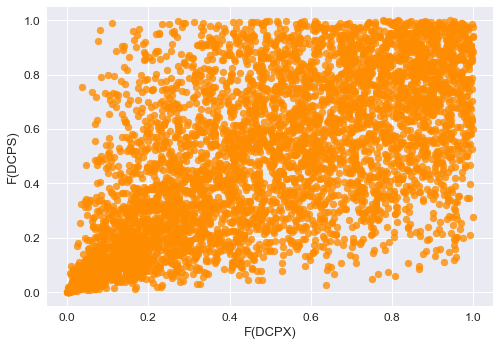

In [50]:
#simulating with this Clayton opula
from pycop.bivariate import simulation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn') 
u1, u2 = simulation.simu_clayton(num=5000, theta=dist4.theta)
plt.scatter(u1, u2, color="darkorange", alpha=0.8)
plt.xlabel("F(DCPX)", fontsize=13)
plt.ylabel("F(DCPS)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('cop_dcpx_dcps.png', dpi=300, bbox_inches='tight')